In [20]:
from pymongo import MongoClient
import pandas as pd

# MongoDB setup
client = MongoClient('mongodb://localhost:27017')
db = client['IM_Project']

# Importing links.csv
links = pd.read_csv('links.csv')
collection_links = db['links']
collection_links.insert_many(links.to_dict('records'))

# Importing movies.csv
movies = pd.read_csv('movies.csv')
collection_movies = db['movies']
collection_movies.insert_many(movies.to_dict('records'))

# Importing tags.csv
tags = pd.read_csv('tags.csv')
collection_tags = db['tags']
collection_tags.insert_many(tags.to_dict('records'))

# Importing ratings.csv
ratings = pd.read_csv('ratings.csv')
collection_ratings = db['ratings']
collection_ratings.insert_many(ratings.to_dict('records'))


# Close the MongoDB connection
client.close()


In [21]:
# MongoDB setup
client = MongoClient('mongodb://localhost:27017')
db = client['IM_Project']

# Function to convert a MongoDB collection to a Pandas DataFrame
def collection_to_dataframe(collection_name):
    collection = db[collection_name]
    data = pd.DataFrame(list(collection.find({})))
    return data

# Retrieving data for all four collections and converting to DataFrames
links = collection_to_dataframe('links')
movies = collection_to_dataframe('movies')
tags = collection_to_dataframe('tags')
ratings = collection_to_dataframe('ratings')
keywords = collection_to_dataframe('keywords')
credits = collection_to_dataframe('credits')

# Displaying the first few rows of each DataFrame
print("Links DataFrame:")
print(links.head())
print("\nMovies DataFrame:")
print(movies.head())
print("\nTags DataFrame:")
print(tags.head())
print("\nRatings DataFrame:")
print(ratings.head())

# Closing the MongoDB connection
client.close()


Links DataFrame:
                        _id  movieId  imdbId   tmdbId
0  655c7b3298183e5ff2dc6a05        1  114709    862.0
1  655c7b3298183e5ff2dc6a06        2  113497   8844.0
2  655c7b3298183e5ff2dc6a07        3  113228  15602.0
3  655c7b3298183e5ff2dc6a08        4  114885  31357.0
4  655c7b3298183e5ff2dc6a09        5  113041  11862.0

Movies DataFrame:
                        _id  movieId                               title  \
0  655c7b3398183e5ff2dc9013        1                    Toy Story (1995)   
1  655c7b3398183e5ff2dc9014        2                      Jumanji (1995)   
2  655c7b3398183e5ff2dc9015        3             Grumpier Old Men (1995)   
3  655c7b3398183e5ff2dc9016        4            Waiting to Exhale (1995)   
4  655c7b3398183e5ff2dc9017        5  Father of the Bride Part II (1995)   

                                        genres  
0  Adventure|Animation|Children|Comedy|Fantasy  
1                   Adventure|Children|Fantasy  
2                               Come

In [4]:
len(links)

19484

In [5]:
len(movies)

19484

In [6]:
len(tags)

7366

In [7]:
len(ratings)

201672

<div class="alert alert-block alert-success"> <strong> Indexing </strong>

In [ ]:
# MongoDB setup
client = MongoClient('mongodb://localhost:27017')
db = client['IM_Project']

# Creating an index on movieId in the movies collection
db['movies'].create_index([('movieId', 1)])

# Creating an index on movieId in the links collection
db['links'].create_index([('movieId', 1)])

# Creating a compound index on userId and movieId in the tags collection
db['tags'].create_index([('userId', 1), ('movieId', 1)])

# Creating a compound index on userId and movieId in the ratings collection
db['ratings'].create_index([('userId', 1), ('movieId', 1)])

# Close the MongoDB connection
client.close()


<div class="alert alert-block alert-success"> <strong> EDA </strong>

<div class="alert alert-block alert-success"> <strong> Data Distribution Analysis </strong>

In [84]:
# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017')
db = client['IM_Project']

# Aggregation pipeline
pipeline = [
    {"$project": {"genres": {"$split": ["$genres", "|"]}}},
    {"$unwind": "$genres"},
    {"$group": {"_id": "$genres", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}}
]

# Execute the query
genre_counts = db.movies.aggregate(pipeline)

# Convert to DataFrame
genre_counts = pd.DataFrame(genre_counts)

# Close the MongoDB connection
client.close()


In [85]:
genre_counts

,_id,count
0,Drama,13083
1,Comedy,11268
2,Thriller,5682
3,Action,5484
4,Romance,4788
5,Adventure,3789
6,Crime,3597
7,Sci-Fi,2940
8,Horror,2934
9,Fantasy,2337


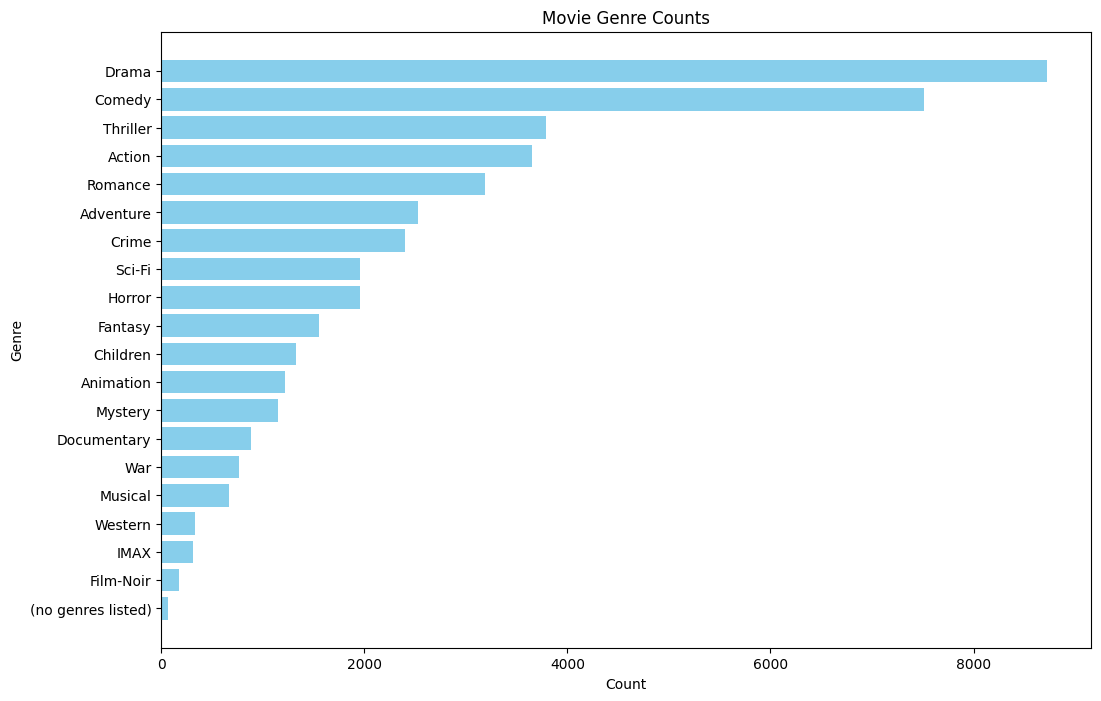

In [52]:
import matplotlib.pyplot as plt

# Data from the genre_counts DataFrame
genre_counts_df = pd.DataFrame({
    'Genre': genre_counts['_id'],
    'Count': genre_counts['count']
})

# Sort the data by count in descending order for better visualization
genre_counts_df = genre_counts_df.sort_values(by='Count', ascending=False)

# Create the bar chart
plt.figure(figsize=(12, 8))
plt.barh(genre_counts_df['Genre'], genre_counts_df['Count'], color='skyblue')
plt.xlabel('Count')
plt.ylabel('Genre')
plt.title('Movie Genre Counts')
plt.gca().invert_yaxis()  # Reverse the order to show the highest count at the top

# Display the plot
plt.show()


In [90]:
client = MongoClient('mongodb://localhost:27017')
db = client['IM_Project']

# Aggregation pipeline
pipeline = [
    # Join with the ratings collection
    {
        "$lookup": {
            "from": "ratings",
            "localField": "movieId",
            "foreignField": "movieId",
            "as": "movie_ratings"
        }
    },
    # Unwind the resulting array to deconstruct the joined data
    {"$unwind": "$movie_ratings"},
    # Split the genres field and unwind it
    {"$project": {"genres": {"$split": ["$genres", "|"]}, "rating": "$movie_ratings.rating"}},
    {"$unwind": "$genres"},
    # Group by genre and calculate the average rating and count
    {
        "$group": {
            "_id": "$genres",
            "average_rating": {"$avg": "$rating"},
            "count": {"$sum": 1}
        }
    },
    # Sort by the count (or average_rating if desired)
    {"$sort": {"count": -1}}
]

# Execute the query
genre_stats = db.movies.aggregate(pipeline)

# Convert to DataFrame
genre_stats_df = pd.DataFrame(list(genre_stats))

# Close the MongoDB connection
client.close()



In [91]:
genre_stats_df

,_id,average_rating,count
0,Drama,3.656184,377352
1,Comedy,3.384721,351477
2,Action,3.447984,275715
3,Thriller,3.493706,238068
4,Adventure,3.508609,217449
5,Romance,3.506511,163116
6,Sci-Fi,3.455721,155187
7,Crime,3.658294,150129
8,Fantasy,3.491001,106506
9,Children,3.412956,82872


In [92]:
# Sum of the 'count' column in the genre_stats_df DataFrame
total_count = genre_stats_df['count'].sum()

# Print the total count
print("Total count of all genres:", total_count)


Total count of all genres: 2470320


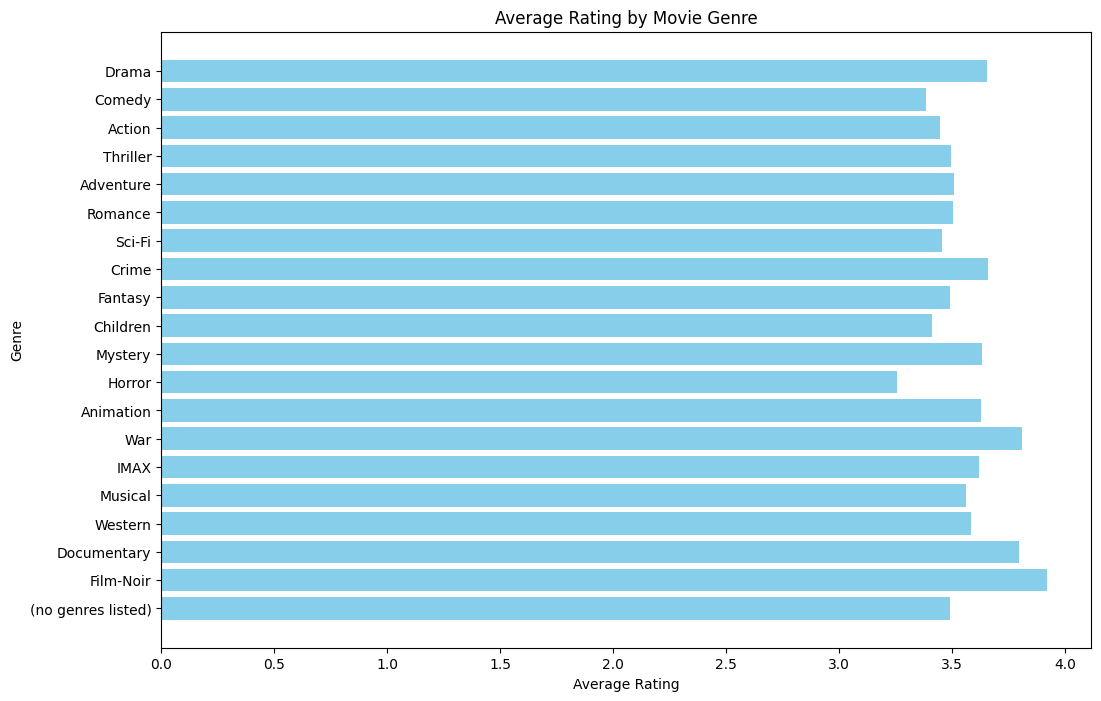

In [94]:
# Plotting code
plt.figure(figsize=(12, 8))
plt.barh(genre_stats_df['_id'], genre_stats_df['average_rating'], color='skyblue')
plt.xlabel('Average Rating')
plt.ylabel('Genre')
plt.title('Average Rating by Movie Genre')
plt.gca().invert_yaxis()  # Invert y-axis to have the genre with the highest count at the top
plt.show()


In [10]:
# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017')
db = client['IM_Project']

# Aggregation pipeline to calculate tag frequency
pipeline = [
    {"$unwind": "$tag"},
    {"$group": {"_id": "$tag", "count": {"$sum": 1}}},
    {"$sort": {"count": -1}}
]

# Execute the query
tag_counts = db.tags.aggregate(pipeline)

# Convert to DataFrame
tag_counts = pd.DataFrame(tag_counts)

# Export to CSV
tag_counts.to_csv('tag_counts.csv', index=False)

# Close the MongoDB connection
client.close()


In [11]:
tag_counts

,_id,count
0,In Netflix queue,262
1,atmospheric,72
2,superhero,48
3,thought-provoking,48
4,Disney,46
...,...,...
1584,bombs,2
1585,Stand Up,2
1586,unoriginal,2
1587,mental hospital,2


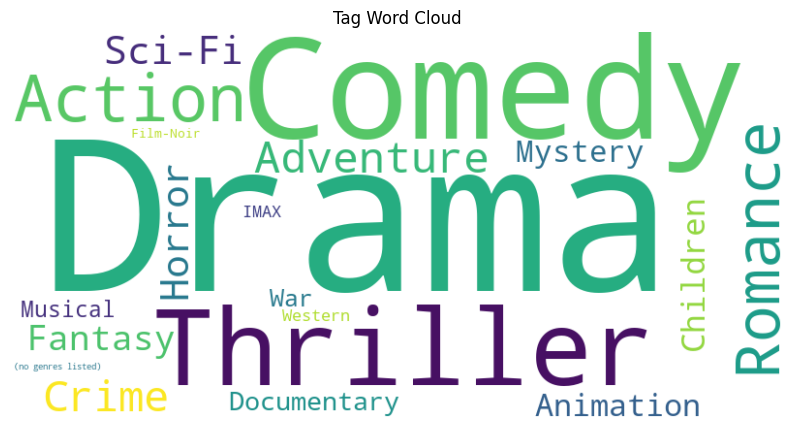

In [55]:
from wordcloud import WordCloud

# Data from the tag_counts DataFrame
tag_counts_df = pd.DataFrame({
     'Tag': genre_counts['_id'],
    'Count': genre_counts['count']
})

# Create a dictionary with tags as keys and counts as values
tag_dict = dict(zip(tag_counts_df['Tag'], tag_counts_df['Count']))

# Create the WordCloud object
wordcloud = WordCloud(width=800, height=400, background_color='white').generate_from_frequencies(tag_dict)

# Create a figure and plot the word cloud
plt.figure(figsize=(10, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis labels and ticks
plt.title('Tag Word Cloud')
plt.show()


In [15]:
# QC
# Calculate tag counts
tag_counts_1 = tags['tag'].value_counts()
tag_counts_1

In Netflix queue     262
atmospheric           72
thought-provoking     48
superhero             48
funny                 46
                    ... 
small towns            2
In Your Eyes           2
Lloyd Dobbler          2
weak plot              2
Heroic Bloodshed       2
Name: tag, Length: 1589, dtype: int64

In [69]:
from pymongo import MongoClient
import re

client = MongoClient('mongodb://localhost:27017')
db = client['IM_Project']

# Update each document in the 'movies' collection to include the 'year' field
for doc in db.movies.find():
    match = re.search(r'\((\d{4})\)$', doc['title'])
    if match:
        year = int(match.group(1))
        db.movies.update_one({'_id': doc['_id']}, {'$set': {'year': year}})

client.close()


In [70]:
client = MongoClient('mongodb://localhost:27017')
db = client['IM_Project']

# Create indexes
db.movies.create_index("movieId")
db.ratings.create_index("movieId")
db.movies.create_index("year")

client.close()


In [71]:
import pandas as pd

client = MongoClient('mongodb://localhost:27017')
db = client['IM_Project']

# Aggregation pipeline
pipeline = [
    {
        "$lookup": {
            "from": "ratings",
            "localField": "movieId",
            "foreignField": "movieId",
            "as": "movie_ratings"
        }
    },
    {"$unwind": "$movie_ratings"},
    {
        "$project": {
            "year": 1,  # Using the directly stored year
            "rating": "$movie_ratings.rating"
        }
    },
    {"$match": {"year": {"$gte": 1900}}},  # Assuming all valid years are >= 1900
    {
        "$group": {
            "_id": "$year",
            "total_ratings": {"$sum": 1},
            "average_rating": {"$avg": "$rating"}
        }
    },
    {"$sort": {"_id": 1}}
]

# Execute the query
yearly_ratings = db.movies.aggregate(pipeline)

# Convert to DataFrame
yearly_ratings = pd.DataFrame(list(yearly_ratings))

client.close()


In [74]:
yearly_ratings=yearly_ratings[yearly_ratings['_id'] >= 1950]
yearly_ratings

,_id,total_ratings,average_rating
37,1950,1449,3.813665
38,1951,1638,3.804945
39,1952,864,3.953125
40,1953,1377,3.647059
41,1954,2448,4.009191
...,...,...,...
101,2014,11862,3.512140
102,2015,9792,3.410386
103,2016,7065,3.387261
104,2017,4149,3.578091


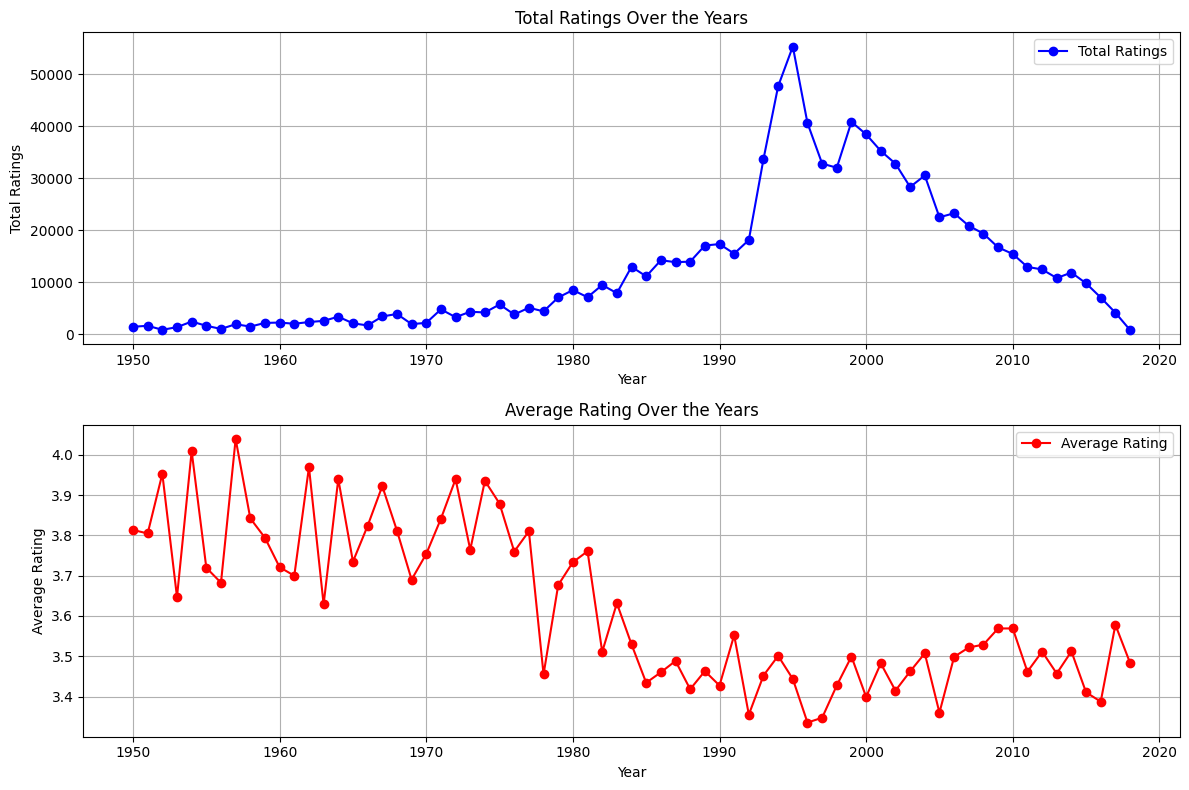

In [76]:
# Extract data from the yearly_ratings DataFrame
years = yearly_ratings['_id']
total_ratings = yearly_ratings['total_ratings']
average_rating = yearly_ratings['average_rating']

# Create a figure with two subplots (one for total ratings and one for average rating)
fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(12, 8))

# Plot total ratings over the years
ax1.plot(years, total_ratings, marker='o', linestyle='-', color='b', label='Total Ratings')
ax1.set_xlabel('Year')
ax1.set_ylabel('Total Ratings')
ax1.set_title('Total Ratings Over the Years')
ax1.grid(True)
ax1.legend()

# Plot average rating over the years
ax2.plot(years, average_rating, marker='o', linestyle='-', color='r', label='Average Rating')
ax2.set_xlabel('Year')
ax2.set_ylabel('Average Rating')
ax2.set_title('Average Rating Over the Years')
ax2.grid(True)
ax2.legend()

# Adjust the layout
plt.tight_layout()

# Show the plot
plt.show()


In [64]:
# QC

# Extracting the year from the movie title
movies['year'] = movies['title'].str.extract(r'\((\d{4})\)')

# Converting year to integer, handling NaN values by converting them to a dummy year (e.g., 0)
movies['year'] = movies['year'].fillna(0).astype(int)

# Merging the Movies and Ratings DataFrames on the movieId column
merged_df = pd.merge(ratings, movies, on='movieId')

# Counting the number of ratings for each year
ratings_count_per_year = merged_df.groupby('year')['rating'].count().reset_index()
ratings_count_per_year.columns = ['year', 'ratings_count']

# Calculating the average rating for each year
average_ratings_per_year = merged_df.groupby('year')['rating'].mean().reset_index()
average_ratings_per_year.columns = ['year', 'average_rating']

# Merging the two DataFrames on the 'year' column
result_df = pd.merge(ratings_count_per_year, average_ratings_per_year, on='year')
result_df = result_df[result_df['year'] >= 1950]
result_df


,year,ratings_count,average_rating
38,1950,1449,3.813665
39,1951,1638,3.804945
40,1952,864,3.953125
41,1953,1377,3.647059
42,1954,2448,4.009191
...,...,...,...
102,2014,11880,3.512879
103,2015,9792,3.410386
104,2016,7065,3.387261
105,2017,4149,3.578091


In [24]:
# Connect to MongoDB
client = MongoClient('mongodb://localhost:27017')
db = client['IM_Project']

# Aggregation pipeline to count ratings per user
pipeline = [
    {"$group": {"_id": "$userId", "ratings_count": {"$sum": 1}}},
    {"$sort": {"ratings_count": -1}}  # Sort by ratings_count in descending order
]

# Execute the query
user_activity = db.ratings.aggregate(pipeline)

# Convert to DataFrame
user_activity = pd.DataFrame(list(user_activity))

# Identifying the most and least active users
most_active_users = user_activity.head()  # Top users
least_active_users = user_activity.tail()  # Bottom users

# Close the MongoDB connection
client.close()

In [77]:
user_activity

,userId,num_ratings
0,414,8094
1,599,7434
2,474,6324
3,448,5592
4,274,4038
...,...,...
605,442,60
606,569,60
607,320,60
608,576,60


In [25]:
most_active_users

,_id,ratings_count
0,414,8094
1,599,7434
2,474,6324
3,448,5592
4,274,4038


In [26]:
least_active_users

,_id,ratings_count
605,576,60
606,320,60
607,442,60
608,207,60
609,569,60


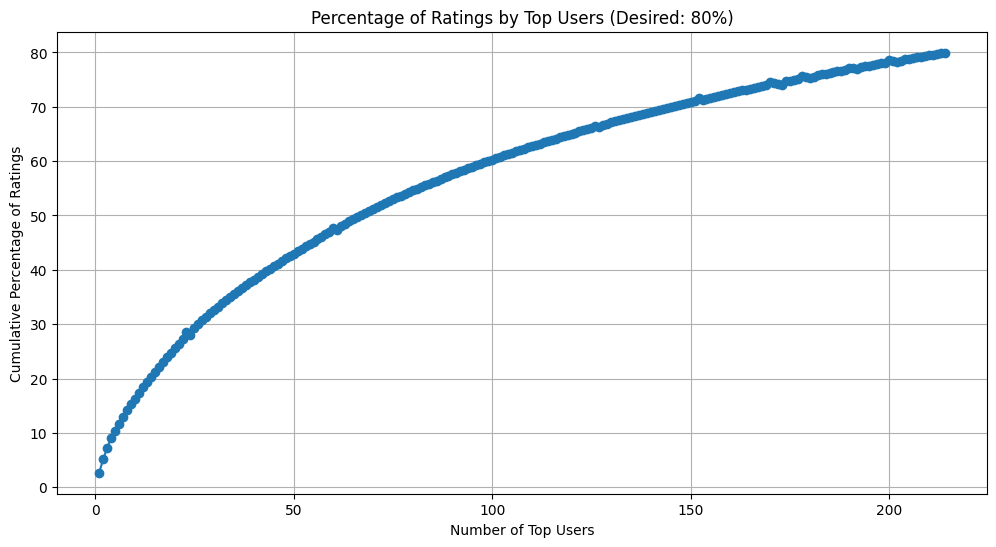

Number of top users responsible for 80% of ratings: 214


In [80]:
import matplotlib.pyplot as plt

# Sort the user_activity DataFrame by num_ratings in descending order
user_activity = user_activity.sort_values(by='num_ratings', ascending=False)

# Calculate the cumulative sum of num_ratings
user_activity['cumulative_sum'] = user_activity['num_ratings'].cumsum()

# Calculate the total number of ratings
total_ratings = user_activity['num_ratings'].sum()

# Define the desired percentage (e.g., 80%)
desired_percentage = 80

# Find the number of top users responsible for the desired percentage of ratings
users_responsible_percentage = user_activity[user_activity['cumulative_sum'] / total_ratings * 100 <= desired_percentage]

# Plot the cumulative percentage of ratings by top users
plt.figure(figsize=(12, 6))
plt.plot(users_responsible_percentage.index + 1, users_responsible_percentage['cumulative_sum'] / total_ratings * 100, marker='o', linestyle='-')
plt.xlabel('Number of Top Users')
plt.ylabel('Cumulative Percentage of Ratings')
plt.title(f'Percentage of Ratings by Top Users (Desired: {desired_percentage}%)')
plt.grid(True)

# Show the plot
plt.show()

# Print the number of top users responsible for the desired percentage of ratings
print(f"Number of top users responsible for {desired_percentage}% of ratings: {len(users_responsible_percentage)}")


In [28]:
# QC

# Counting the number of ratings per user
user_activity = ratings['userId'].value_counts().reset_index()
user_activity.columns = ['userId', 'num_ratings']

# Identifying the most active users
most_active_users = user_activity.nlargest(5, 'num_ratings')

# Identifying the least active users
least_active_users = user_activity.nsmallest(5, 'num_ratings')

print("Most Active Users:\n", most_active_users)
print("\nLeast Active Users:\n", least_active_users)


Most Active Users:
    userId  num_ratings
0     414         8094
1     599         7434
2     474         6324
3     448         5592
4     274         4038

Least Active Users:
      userId  num_ratings
596     595           60
597     189           60
598     207           60
599     194           60
600     147           60


In [40]:
# Remove duplicates based on 'movieId' in movies_df
movies_df_clean = movies.drop_duplicates(subset=['movieId'])

# If needed, remove duplicates from ratings_df as well
# This step depends on the nature of your dataset
ratings_df_clean = ratings.drop_duplicates()

# Calculate average rating and number of ratings for each movie
movie_ratings = ratings_df_clean.groupby('movieId').agg(
    avg_rating=('rating', 'mean'),
    num_ratings=('rating', 'count')
).reset_index()

# Normalize avg_rating and num_ratings to have values between 0 and 1
max_avg_rating = movie_ratings['avg_rating'].max()
max_num_ratings = movie_ratings['num_ratings'].max()

movie_ratings['normalized_avg_rating'] = movie_ratings['avg_rating'] / max_avg_rating
movie_ratings['normalized_num_ratings'] = movie_ratings['num_ratings'] / max_num_ratings

# Calculate popularity score
weight = 0.5
movie_ratings['popularity_score'] = (weight * movie_ratings['normalized_avg_rating']) + \
                                    (weight * movie_ratings['normalized_num_ratings'])

# Merge with movies_df_clean to get movie titles
popular_movies = pd.merge(movie_ratings, movies_df_clean, on='movieId')

# Sort movies by popularity score
popular_movies = popular_movies.sort_values(by='popularity_score', ascending=False)

print(popular_movies[['title', 'avg_rating', 'num_ratings', 'popularity_score']])


                                    title  avg_rating  num_ratings  \
277      Shawshank Redemption, The (1994)    4.429022          951   
314                   Forrest Gump (1994)    4.164134          987   
257                   Pulp Fiction (1994)    4.197068          921   
1938                   Matrix, The (1999)    4.192446          834   
510      Silence of the Lambs, The (1991)    4.161290          837   
...                                   ...         ...          ...   
8694  The Beast of Hollow Mountain (1956)    0.500000            3   
7744              Arthur Christmas (2011)    0.500000            3   
8422           Midnight Chronicles (2009)    0.500000            3   
4433               Born to Be Wild (1995)    0.500000            3   
7666              Pearl Jam Twenty (2011)    0.500000            3   

      popularity_score  
277           0.924665  
314           0.916413  
257           0.886272  
1938          0.841737  
510           0.840141  
...      

In [41]:
popular_movies

,movieId,avg_rating,num_ratings,normalized_avg_rating,normalized_num_ratings,popularity_score,_id,title,genres,year,decade
277,318,4.429022,951,0.885804,0.963526,0.924665,655c7b3398183e5ff2dc9128,"Shawshank Redemption, The (1994)",Crime|Drama,1994,1990
314,356,4.164134,987,0.832827,1.000000,0.916413,655c7b3398183e5ff2dc914d,Forrest Gump (1994),Comedy|Drama|Romance|War,1994,1990
257,296,4.197068,921,0.839414,0.933131,0.886272,655c7b3398183e5ff2dc9114,Pulp Fiction (1994),Comedy|Crime|Drama|Thriller,1994,1990
1938,2571,4.192446,834,0.838489,0.844985,0.841737,655c7b3398183e5ff2dc97a6,"Matrix, The (1999)",Action|Sci-Fi|Thriller,1999,1990
510,593,4.161290,837,0.832258,0.848024,0.840141,655c7b3398183e5ff2dc9211,"Silence of the Lambs, The (1991)",Crime|Horror|Thriller,1991,1990
...,...,...,...,...,...,...,...,...,...,...,...
8694,125221,0.500000,3,0.100000,0.003040,0.051520,655c7b3398183e5ff2dcb21b,The Beast of Hollow Mountain (1956),Horror|Sci-Fi|Western,1956,1950
7744,91414,0.500000,3,0.100000,0.003040,0.051520,655c7b3398183e5ff2dcae65,Arthur Christmas (2011),Animation|Children|Comedy|Drama,2011,2010
8422,111785,0.500000,3,0.100000,0.003040,0.051520,655c7b3398183e5ff2dcb10b,Midnight Chronicles (2009),Action|Adventure|Fantasy,2009,2000
4433,6557,0.500000,3,0.100000,0.003040,0.051520,655c7b3398183e5ff2dca16a,Born to Be Wild (1995),Adventure|Children|Comedy|Drama,1995,1990


<div class="alert alert-block alert-success"> <strong> User-User Collaborative Filtering </strong>

In [76]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from sklearn.metrics import mean_squared_error
from math import sqrt


# Split the data into training and test sets (80-20 split for each user)
train_ratings, test_ratings = train_test_split(ratings, test_size=0.4)

# Create user-item matrices for training and testing
train_matrix = train_ratings.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)
test_matrix = test_ratings.pivot_table(index='userId', columns='movieId', values='rating').fillna(0)

# Convert the user-item matrices to sparse matrix format
train_sparse_matrix = sparse.csr_matrix(train_matrix.values)
test_sparse_matrix = sparse.csr_matrix(test_matrix.values)

# Compute the cosine similarity matrix (user-user similarity) based on training data
user_similarity = cosine_similarity(train_sparse_matrix)

# Convert to DataFrame for better readability
user_similarity_df = pd.DataFrame(user_similarity, index=train_matrix.index, columns=train_matrix.index)

def recommend_movies(user_id, user_similarity_df, user_movie_matrix, n_recommendations=5):
    # Check if user_id exists in user_similarity_df
    if user_id not in user_similarity_df.columns:
        return []

    # Get similarity scores for the user in question with all other users
    user_similarity_scores = user_similarity_df[user_id]

    # Sort the users based on similarity scores
    similar_users = user_similarity_scores.sort_values(ascending=False)

    # Get the movies rated by the most similar users
    similar_users = similar_users.drop(user_id).index  # Exclude the user itself
    recommended_movies = user_movie_matrix.loc[similar_users].mean().sort_values(ascending=False)

    # Filter out movies the user has already rated
    already_rated = user_movie_matrix.loc[user_id] > 0
    recommended_movies = recommended_movies[~already_rated]

    return recommended_movies.head(n_recommendations).index.tolist()

def evaluate_recommendations(test_set, user_similarity_df, user_movie_matrix, n_recommendations=5):
    mse_sum = 0
    users_tested = 0

    for user_id in test_set.index:
        if user_id in user_movie_matrix.index:
            actual_ratings = test_set.loc[user_id]
            actual_rated_movies = actual_ratings[actual_ratings > 0].index
            predicted_movie_ids = recommend_movies(user_id, user_similarity_df, user_movie_matrix, n_recommendations)

            # Predict ratings for recommended movies
            predicted_ratings = user_movie_matrix.loc[user_id, predicted_movie_ids]

            # Calculate MSE for this user (comparing predicted vs. actual ratings for the recommended movies)
            mse = mean_squared_error(actual_ratings.loc[predicted_movie_ids], predicted_ratings, squared=False)
            mse_sum += mse
            users_tested += 1

    return mse_sum / users_tested if users_tested > 0 else float('nan')

# Evaluate the recommendations
test_rmse = evaluate_recommendations(test_matrix, user_similarity_df, train_matrix)
print("Test RMSE:", test_rmse)


Test RMSE: 0.13534680317291772


<div class="alert alert-block alert-success"> <strong> Item-Item Collaborative Filtering </strong>

In [75]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics.pairwise import cosine_similarity
from scipy import sparse
from sklearn.metrics import mean_squared_error
from math import sqrt

# Split the data into training and test sets (80-20 split for each movie)
train_ratings, test_ratings = train_test_split(ratings, test_size=0.4)

# Create item-user matrices for training and testing
train_matrix = train_ratings.pivot_table(index='movieId', columns='userId', values='rating').fillna(0)
test_matrix = test_ratings.pivot_table(index='movieId', columns='userId', values='rating').fillna(0)

# Convert the item-user matrices to sparse matrix format
train_sparse_matrix = sparse.csr_matrix(train_matrix.values)
test_sparse_matrix = sparse.csr_matrix(test_matrix.values)

# Compute the cosine similarity matrix (item-item similarity) based on training data
item_similarity = cosine_similarity(train_sparse_matrix.T)  # Transpose for item-item similarity

# Convert to DataFrame for better readability
item_similarity_df = pd.DataFrame(item_similarity, index=train_matrix.columns, columns=train_matrix.columns)

def recommend_movies(movie_id, item_similarity_df, user_movie_matrix, n_recommendations=5):
    # Check if movie_id exists in item_similarity_df
    if movie_id not in item_similarity_df.index:
        return []

    # Get similarity scores for the movie in question with all other movies
    item_similarity_scores = item_similarity_df[movie_id]

    # Sort the movies based on similarity scores
    similar_movies = item_similarity_scores.sort_values(ascending=False)

    # Get the users who have rated the most similar movies
    similar_movies = similar_movies.drop(movie_id).index  # Exclude the movie itself
    recommended_users = user_movie_matrix[similar_movies].mean(axis=1).sort_values(ascending=False)

    # Filter out movies already rated by the user
    already_rated = user_movie_matrix.loc[:, movie_id] > 0
    recommended_users = recommended_users[~already_rated]

    return recommended_users.head(n_recommendations).index.tolist()

def evaluate_recommendations_item_item(test_set, item_similarity_df, user_movie_matrix, n_recommendations=5):
    mse_sum = 0
    movies_tested = 0

    for movie_id in test_set.columns:
        if movie_id in user_movie_matrix.columns:
            actual_ratings = test_set.loc[:, movie_id]
            actual_rated_users = actual_ratings[actual_ratings > 0].index
            predicted_user_ids = recommend_movies(movie_id, item_similarity_df, user_movie_matrix, n_recommendations)

            # Predict ratings for recommended users
            predicted_ratings = user_movie_matrix.loc[predicted_user_ids, movie_id]

            # Calculate MSE for this movie (comparing predicted vs. actual ratings for the recommended users)
            mse = mean_squared_error(actual_ratings.loc[predicted_user_ids], predicted_ratings, squared=False)
            mse_sum += mse
            movies_tested += 1

    return mse_sum / movies_tested if movies_tested > 0 else float('nan')

# Evaluate the recommendations for item-item collaborative filtering
test_rmse_item_item = evaluate_recommendations_item_item(test_matrix, item_similarity_df, train_matrix)
print("Item-Item Collaborative Filtering Test RMSE:", test_rmse_item_item)


Item-Item Collaborative Filtering Test RMSE: 0.35440928368400326
